# Monte Carlo法以及MCMC
## 简单的Monte Carlo
令$\left(x_1,x_2\right)\in\left[-1,1\right]\times\left[-1,1\right]$，以及：$$h\left(x_1,x_2\right)=\frac{1}{2}\exp\left\{ -90\left(x_1-0.5\right)^{2}-45\left(x_2+0.1\right)^{2}\right\} $$
为了计算：$$I=\int h\left(x\right)dx$$
我们可以先在$\left[-1,1\right]\times\left[-1,1\right]$的均匀分布中进行抽样，其密度函数为$f\left(x\right)=\frac{1}{4}$，从而数值积分为：$$\hat{I}=\frac{1}{N}\sum_{i=1}^{N}\frac{h\left(x_{i}\right)}{f\left(x_{i}\right)}=\frac{4}{N}\sum_{i=1}^{N}h\left(x_{i}\right)$$

In [1]:
## MonteCarlo_simple.py
import numpy as np
from numpy import random as nprd
nprd.seed(19880505)

##设定参数
M = 10000
h1 = lambda x: 0.5 * np.exp(-90 * (x[0] - 0.5)**2 - 45 * (x[1] + 0.1)**2)

##抽样
x = [(nprd.random() * 2 - 1, nprd.random() * 2 - 1) for i in range(M)]

##计算h(x)
sample = list(map(h, x))
integral = 4 * np.mean(sample)
se = 4 * np.std(sample) / np.sqrt(M)
subsample_001 = list(filter(lambda x: x > 0.01, sample))
print("Intgral=", integral)
print("s.e. of Integral=", se)
print("95% C.I.:", integral - 1.96 * se, "~", integral + 1.96 * se)
print("Ratio of >0.01 samples:", len(subsample_001) / M)

NameError: name 'h' is not defined

## 重要性抽样
### 算法1
首先，我们可以使用一个工具分布，比如$x_1\sim N\left(0.5,\frac{1}{180}\right)$,$x_2\sim N\left(-0.1,\frac{1}{90}\right)$进行抽样，假设该联合分布函数为$m\left(x_1,x_2\right)$，然后计算$$\hat{I}=\frac{1}{N}\sum_{i=1}^{N}h\left(x_{i}\right)\frac{\pi\left(x_{i}\right)}{m\left(x_{i}\right)}$$

In [ ]:
## importance_sampling.py
import numpy as np
from numpy import random as nprd
##设定参数
M = 10000
h1 = lambda x: 0.5 * np.exp(-90 * (x[0] - 0.5)**2 - 45 * (x[1] + 0.1)**2)
domain = lambda x: (x[0] >= -1) * (x[1] >= -1) * (x[0] <= 1) * (x[1] <= 1)
pai = lambda x: 1 / 4 * domain(x)
h1_star = lambda x: 4 * h1(x)
mu1 = 0.5
mu2 = -0.1
sigma1 = np.sqrt(1 / 180)
sigma2 = np.sqrt(1 / 90)
m = lambda x: 1/(2 * np.pi * sigma1 * sigma2) * \
    np.exp(-1 * (x[0]-mu1)**2/(2 * sigma1**2)\
           - (x[1]-mu2)**2 / (2 * sigma2**2))

#从m(x)中采样
x = [(nprd.normal(mu1, sigma1), nprd.normal(mu2, sigma2))\
   for i in range(M)]

## 计算积分
H = list(map(lambda x: h1_star(x) * pai(x) / m(x), x))
integral = np.mean(H)
se = np.std(H) / np.sqrt(M)
print("Intgral=", integral)
print("s.e. of Integral=", se)
print("95% C.I.:", integral - 1.96 * se, "~", integral + 1.96 * se)

Intgral= 0.02468268298976871
s.e. of Integral= 7.83227169136638e-20
95% C.I.: 0.02468268298976871 ~ 0.02468268298976871


### 算法2
在重要性抽样的第二种算法中，为了计算第一部分的积分，我们首先使用拒绝采样法，从$$g\left(x_1,x_2\right)\propto\exp\left\{ -90\left(x_1-0.5\right)^{2}-45\left(x_2+0.1\right)^{2}\right\} \cdot1\left\{ -1\leq x_1\leq1\right\} \cdot1\left\{ -1\leq x_2\leq1\right\}$$
中进行抽样，然后使用公式：$$\check{I}=\frac{\sum_{i=1}^{N}\frac{h\left(x_{1i},x_{2i}\right)}{\left|h\left(x_{1i},x_{2i}\right)\right|}}{\sum_{i=1}^{N}\frac{1}{\left|h\left(x_{1i},x_{2i}\right)\right|}}=\frac{\sum_{i=1}^{N}\frac{h_{1}\left(x_{1i},x_{2i}\right)}{\left|h_{1}\left(x_{1i},x_{2i}\right)\right|}}{\sum_{i=1}^{N}\frac{1}{\left|4h_{1}\left(x_{1i},x_{2i}\right)\right|}}=\frac{4}{\frac{1}{N}\sum_{i=1}^{N}\frac{1}{\left|h_{1}\left(x_{1i},x_{2i}\right)\right|}}$$
计算该积分。（详细推导过程见讲义，注意该方法是错的。）

In [ ]:
## importance_sampling2.py
import numpy as np
from numpy import random as nprd

##设定参数
M = 10000
h1 = lambda x: 0.5 * np.exp(-90 * (x[0] - 0.5)**2 - 45 * (x[1] + 0.1)**2)
domain = lambda x: (x[0] >= -1) * (x[1] >= -1) * (x[0] <= 1) * (x[1] <= 1)
pai = lambda x: 1 / 4 * domain(x)
h = lambda x: 4 * h1(x)
l = lambda x: np.exp(-90 * (x[0] - 0.5)**2 - 45 * (x[1] + 0.1)**2) * domain(x)

##拒绝采样法的参数
mu1 = 0.5
mu2 = -0.1
sigma1 = np.sqrt(1 / 180)
sigma2 = np.sqrt(1 / 90)
m=lambda x: 1/(2*np.pi*sigma1*sigma2)* \
    np.exp(-1*(x[0]-mu1)**2/(2*sigma1**2)\
           -(x[1]-mu2)**2/(2*sigma2**2))
x_star = mu1
y_star = mu2
R = l((x_star, y_star)) / m((x_star, y_star))
r = lambda x: l(x) / (R * m(x))


##拒绝采样,从g(x)∝l(x)中采样
def sampling(N_samples):
    X = []
    for i in range(N_samples):
        while True:
            #从m(x)中采样
            x1 = nprd.normal(mu1, sigma1)
            x2 = nprd.normal(mu2, sigma2)
            #拒绝
            if nprd.uniform() < r((x1, x2)):
                X.append((x1, x2))
                break
    return X


## 计算积分
x = sampling(M)
H = list(map(h, x))
Weight = list(map(lambda x: pai(x) / l(x), x))
HW = [H[i] * Weight[i] for i in range(len(H))]
integral = np.mean(HW) / np.mean(Weight)
print("Intgral=", integral)

                      

Intgral= 0.14073695022511232


# 独立的Metropolis-Hastings算法

我们可以使用如下的代码实现独立的Metropolis-Hastings算法:

In [ ]:
##独立的MCMC算法，输入：
##    N_samples  : 抽样次数
##      pai(x)   : 目标密度函数
##      q(y)     : 工具密度函数
##   q_sampler   : 给定x，从q中抽样的函数
##      x0       : 初始值
def MH_independent(N_samples, pai, q, q_sampler, x0):
    X = []
    x = x0
    for i in range(N_samples):
        y = q_sampler()
        rho = min(1, pai(y) * q(x) / (pai(x) * q(y)))
        if nprd.uniform() <= rho:
            X.append(y)
            x = y
        else:
            X.append(x)
    return X

## 使用独立的Metropolis-Hastings算法从Beta分布中采样
为了从Beta分布：$$f\left(x|\alpha,\beta\right)=\frac{1}{B\left(\alpha,\beta\right)}x^{\alpha-1}\left(1-x\right)^{\beta-1}$$中抽样，注意到Beta分布的取值范围为$\left[0,1\right]$，不妨选取$q\left(y\right)$为$\left[0,1\right]$上的均匀分布，使用独立的Metropolis-Hastings算法从Beta分布中抽样。

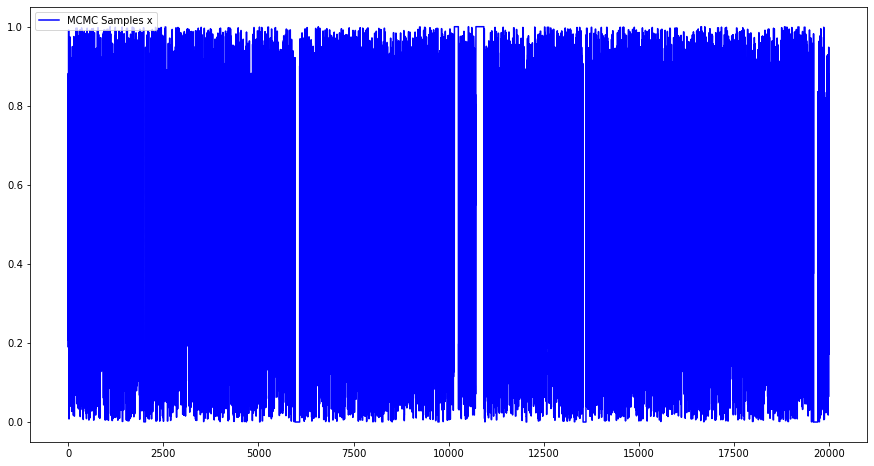

In [ ]:
import numpy as np
from numpy import random as nprd

##设定参数
M =20000
alpha=0.5
beta=0.5
domain=lambda x:(x>0)*(x<1)
pai=lambda x: x**(alpha-1)*(1-x)**(beta-1)*domain(x)
q=lambda y: 1
#从均匀分布中采样
def sample_q():
    return (nprd.uniform())


## 计算积分
x=MH_independent(M, pai, q, sample_q, 0.5)
## 取h后面80%的样本
subx=x[int(M*0.2):]
## 诊断图
import matplotlib.pyplot as plt 
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
index=[i for i in range(len(x))]
plt.plot(index,x,label=r'MCMC Samples x',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图


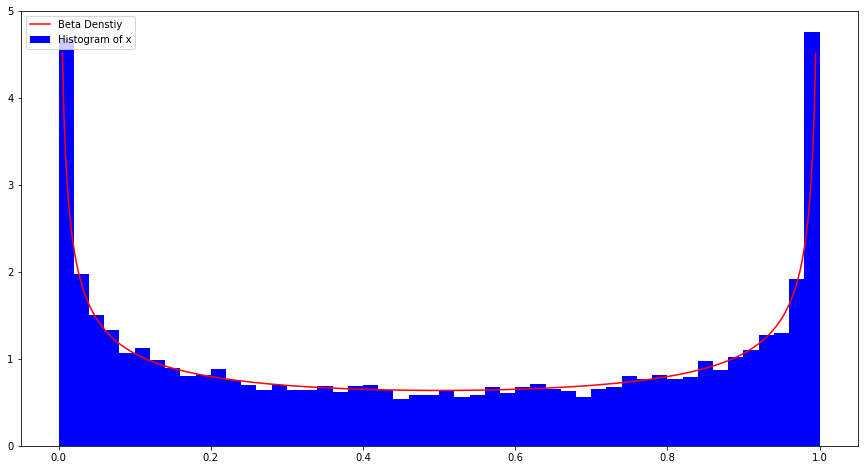

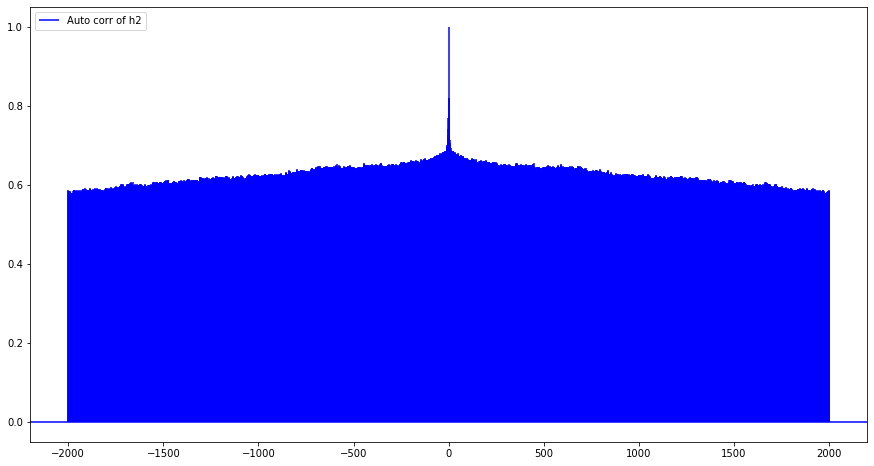

In [ ]:
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
from scipy import special as scsp
index_den=np.linspace(0.005,0.995,500)
density=[1.0/scsp.beta(alpha,beta)*x**(alpha-1)*(1-x)**(beta-1) for x in index_den]
plt.hist(subx,label=r'Histogram of x',color='blue', bins=50,normed=1)
plt.plot(index_den,density,label=r'Beta Denstiy',color='red')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(subx,label=r'Auto corr of h2',color='blue', maxlags=2000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

## 使用独立的Metropolis-Hastings算法计算积分
为了计算以上积分，我们将密度函数改写为：$$\int\int\frac{\pi}{90\sqrt{2}}\cdot1\left\{ -1\leq x_1\leq1\right\} \cdot1\left\{ -1\leq x_2\leq1\right\} \cdot f\left(x_1,x_2\right)dx_1dx_2\overset{\Delta}{=}\frac{\pi}{90\sqrt{2}}\int\int h\left(x_1,x_2\right)\cdot\pi\left(x,y\right)dx_1dx_2$$
接下来使用独立的Metropolis-Hastings算法，选取工具密度$$p\left(y|x\right)=\frac{1}{4}1\left\{ -1\leq y_1\leq1\right\} \cdot1\left\{ -1\leq y_2\leq1\right\} $$进行抽样，得到$\left\{ x_{t},t=1,2,...\right\} $，最终计算积分为：$$\hat{I}=\frac{\pi}{90\sqrt{2}}\frac{1}{M}\sum_{t=1}^{M}h\left(x_{1t},x_{2t}\right)$$

Intgral1= 0.0246826829898
Intgral2= -0.000539202684445


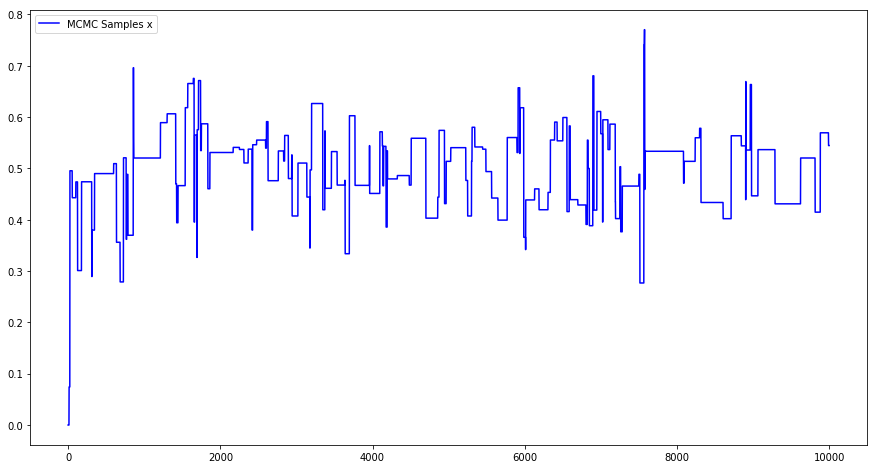

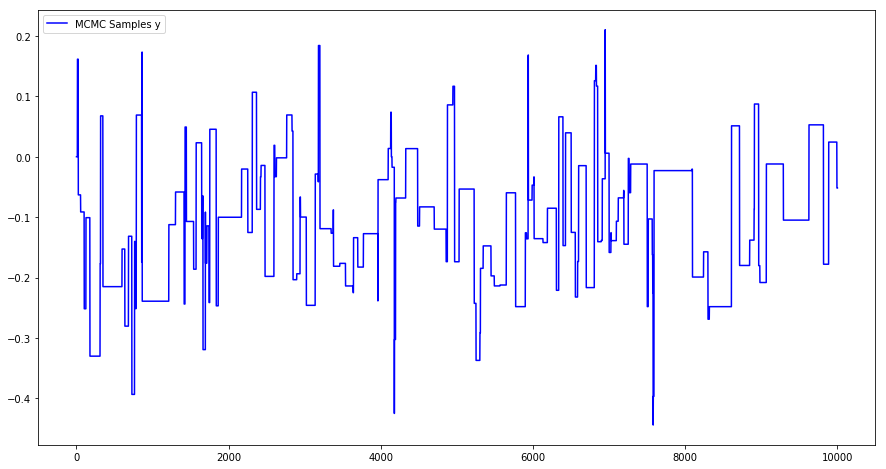

In [ ]:
## MCMC_independent_integ.py

import numpy as np
from numpy import random as nprd

##设定参数
M = 10000
pai_cons = 90 * np.sqrt(2) / (2 * np.pi)
pai = lambda x: pai_cons * \
    np.exp(-90 * (x[0] - 0.5)**2 - 45 * (x[1] + 0.1)**2)
domain = lambda x: (x[0] >= -1) * (x[1] >= -1) * (x[0] <= 1) * (x[1] <= 1)
q = lambda y: 1 / (2 * np.pi) * np.exp(-1 * y[0]**2 / 2 - y[1]**2 / 2)
h = lambda x: domain(x)
h2 = lambda x: np.sin(10 * x[0])**2 + np.log(abs(1 + x[1] * 10))

#从均匀分布中采样
def sample_q():
    return (nprd.normal(), nprd.normal())

## 计算积分
x = MH_independent(M, pai, q, sample_q, (0, 0))
## 第一个积分
H = list(map(h, x))
## 取h后面80%的样本
subH = H[int(M * 0.2):]
integral = np.pi / (90 * np.sqrt(2)) * np.mean(subH)
print("Intgral1=", integral)
## 第二个积分
H2 = list(map(h2, x))
subH2 = H2[int(M * 0.2):]
integral2 = np.pi / (90 * np.sqrt(2)) * np.mean(subH2)
print("Intgral2=", integral2)



直方图：

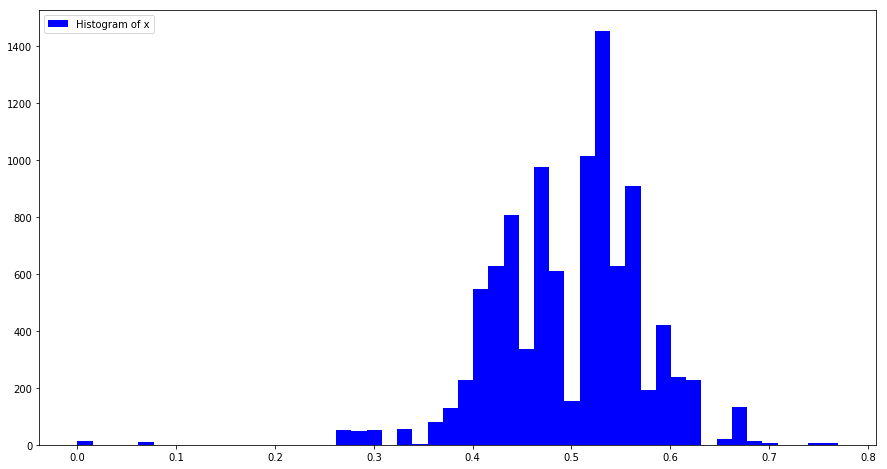

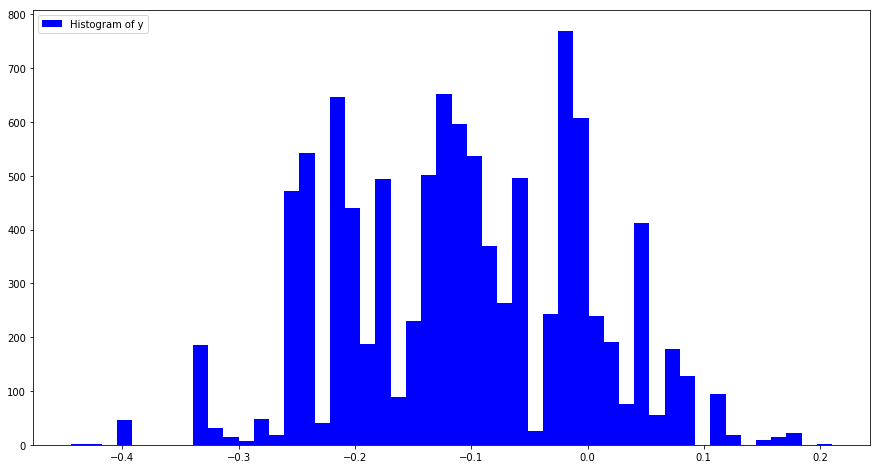

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.hist(x_x,label=r'Histogram of x',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.hist(x_y,label=r'Histogram of y',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

诊断图：

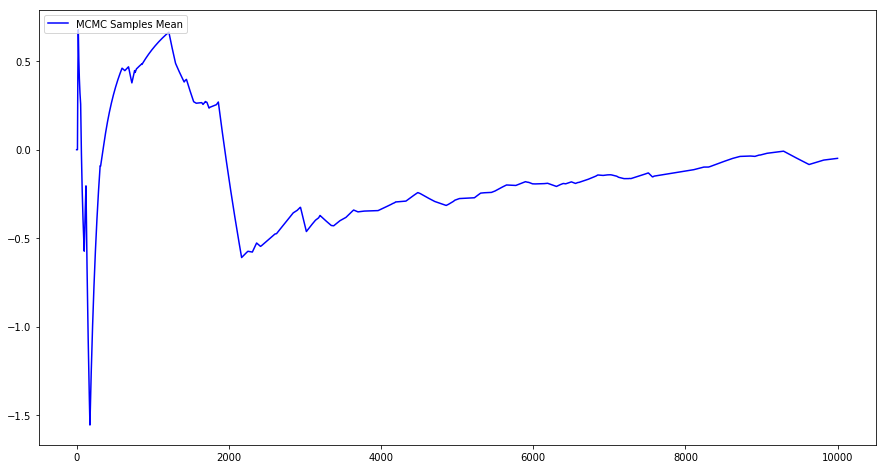

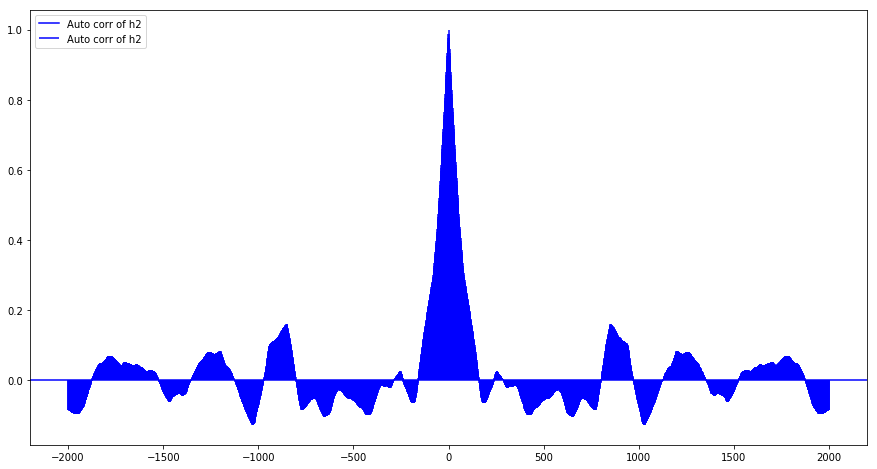

In [ ]:
average_H2=[np.mean(H2[:i]) for i in range(len(H)) if i!=0]
plt.plot(index[1:],average_H2,label=r'MCMC Samples Mean',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(subH2,label=r'Auto corr of h2',color='blue', maxlags=2000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

## 使用随机游走的Metropolis-Hastings算法从Beta分布中采样
为了从Beta分布：$$f\left(x|\alpha,\beta\right)=\frac{1}{B\left(\alpha,\beta\right)}x^{\alpha-1}\left(1-x\right)^{\beta-1}$$中抽样，在这里使用随机游走的Metropolis-Hastings算法，每一步令$y_t=x_t+\epsilon_t$，其中$\epsilon_t\sim N\left(0,0.05^2\right)$

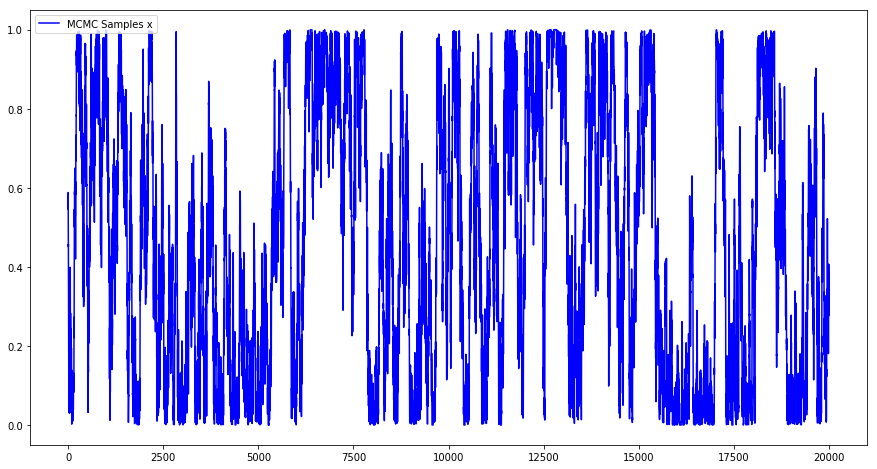

In [ ]:
import numpy as np
from numpy import random as nprd

##设定参数
M =20000
alpha=0.5
beta=0.5
domain=lambda x:(x>0)*(x<1)
pai=lambda x: (x**(alpha-1)*(1-x)**(beta-1) if domain(x)==1 else 0)

#随机游走
def sample_q(x):
    return x+0.05*nprd.normal()


##独立的MCMC算法，输入：
##    N_samples  : 抽样次数
##      pai(x)   : 目标密度函数
##   q_sampler(x): 给定x，从q中抽样的函数
##      x0       : 初始值
def MH_RW(N_samples, pai, q_sampler, x0):
    X=[]
    x=x0
    for i in range(N_samples):
        y=q_sampler(x)
        rho=min(1,pai(y)/pai(x))
        if nprd.uniform()<=rho:
            X.append(y)
            x=y
        else:
            X.append(x)
    return X

## 计算积分
x=MH_RW(M, pai, sample_q, 0.5)
## 取后面80%的样本
subx=x[int(M*0.2):]

## 诊断图
import matplotlib.pyplot as plt 
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
index=[i for i in range(len(x))]
plt.plot(index,x,label=r'MCMC Samples x',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

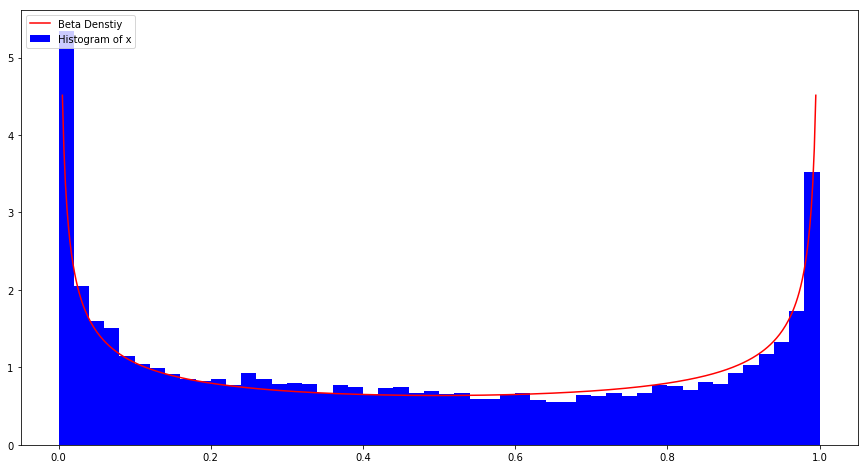

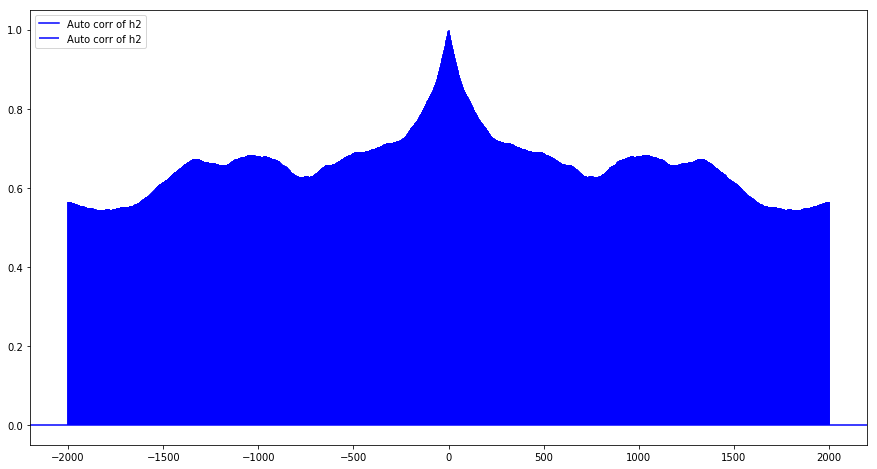

In [ ]:
from scipy import special as scsp
index_den=np.linspace(0.005,0.995,500)
density=[1.0/scsp.beta(alpha,beta)*x**(alpha-1)*(1-x)**(beta-1) for x in index_den]
plt.hist(subx,label=r'Histogram of x',color='blue', bins=50,normed=1)
plt.plot(index_den,density,label=r'Beta Denstiy',color='red')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(subx,label=r'Auto corr of h2',color='blue', maxlags=2000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

## 使用随机游走的Metropolis-Hastings算法计算积分
在这里，我们令$\epsilon_{1,t}\sim N\left(0,0.3^{2}\right)$，$\epsilon_{2,t}\sim N\left(0,0.3^{2}\right)$以及：$$y_{1t}=x_{1t}+\epsilon_{1,t}$$ $$y_{2t}=x_{2t}+\epsilon_{2,t}$$
对马尔可夫链进行更新。

Intgral1= 0.0246826829898
Intgral2= 0.000607347351824


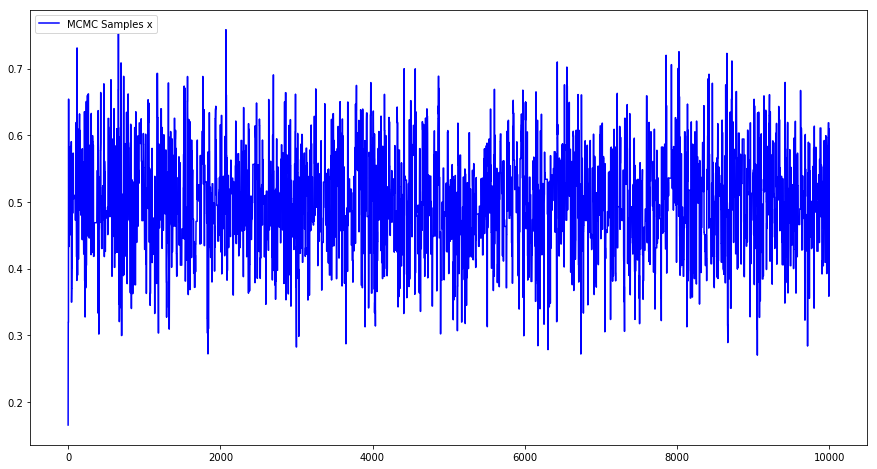

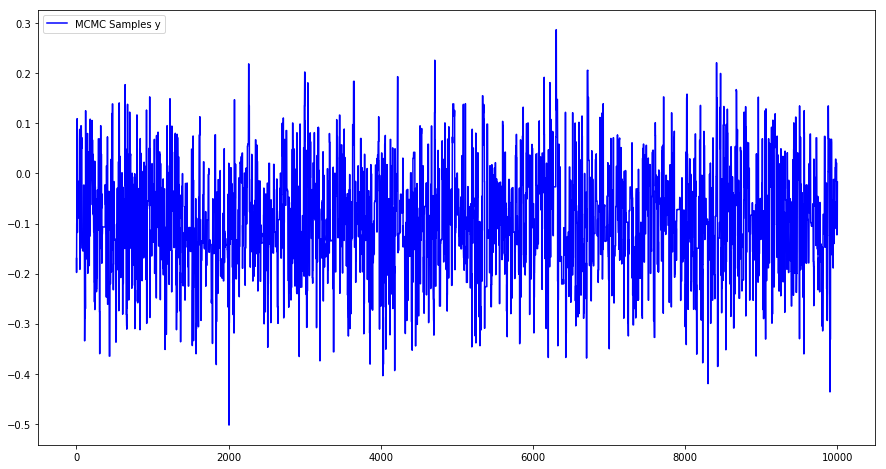

In [ ]:
import numpy as np
from numpy import random as nprd

##设定参数
M =10000
pai=lambda x: np.exp(-90*(x[0]-0.5)**2-45*(x[1]+0.1)**2)
domain=lambda x:(x[0]>=-1)*(x[1]>=-1)*(x[0]<=1)*(x[1]<=1)
h=lambda x: domain(x)
h2=lambda x: np.sin(10*x[0])**2+np.log(abs(1+x[1]*10))

#随机游走
def sample_q(x):
    return (x[0]+0.2*nprd.normal(),x[1]+0.2*nprd.normal())


##独立的MCMC算法，输入：
##    N_samples  : 抽样次数
##      pai(x)   : 目标密度函数
##   q_sampler(x): 给定x，从q中抽样的函数
##      x0       : 初始值
def MH_RW(N_samples, pai, q_sampler, x0):
    X=[]
    x=x0
    for i in range(N_samples):
        y=q_sampler(x)
        rho=min(1,pai(y)/pai(x))
        if nprd.uniform()<=rho:
            X.append(y)
            x=y
        else:
            X.append(x)
    return X

## 计算积分
x=MH_RW(M, pai, sample_q, (0,0))
## 第一个积分
H=list(map(h,x))
## 取h后面80%的样本
subH=H[int(M*0.2):]
integral=np.pi/(90*np.sqrt(2))*np.mean(subH)
print("Intgral1=",integral)
## 第二个积分
H2=list(map(h2,x))
subH2=H2[int(M*0.2):]
integral2=np.pi/(90*np.sqrt(2))*np.mean(subH2)
print("Intgral2=",integral2)

## 诊断图
import matplotlib.pyplot as plt 
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
index=[i for i in range(len(H))]
x_x=[x[i][0] for i in range(len(H))]
x_y=[x[i][1] for i in range(len(H))]
plt.plot(index,x_x,label=r'MCMC Samples x',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.plot(index,x_y,label=r'MCMC Samples y',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图


直方图

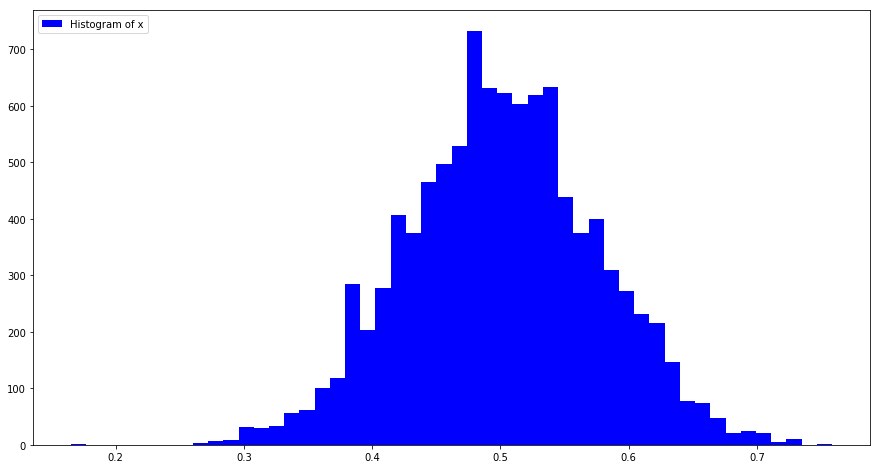

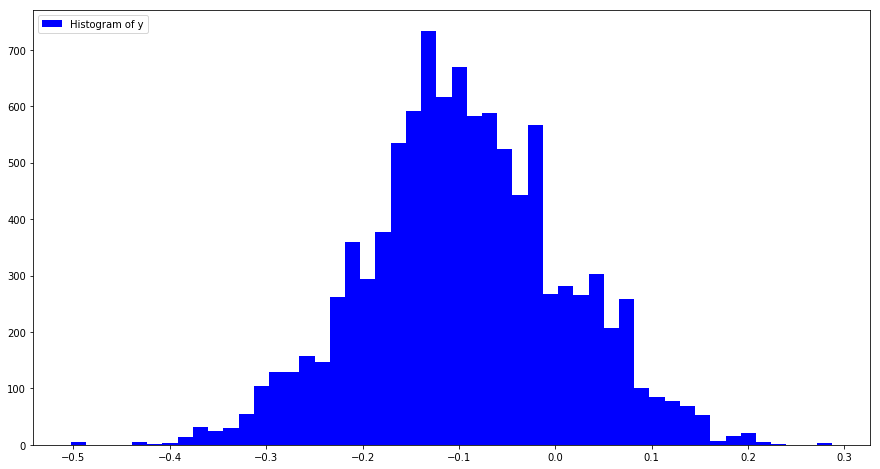

In [ ]:
plt.hist(x_x,label=r'Histogram of x',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.hist(x_y,label=r'Histogram of y',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

诊断图

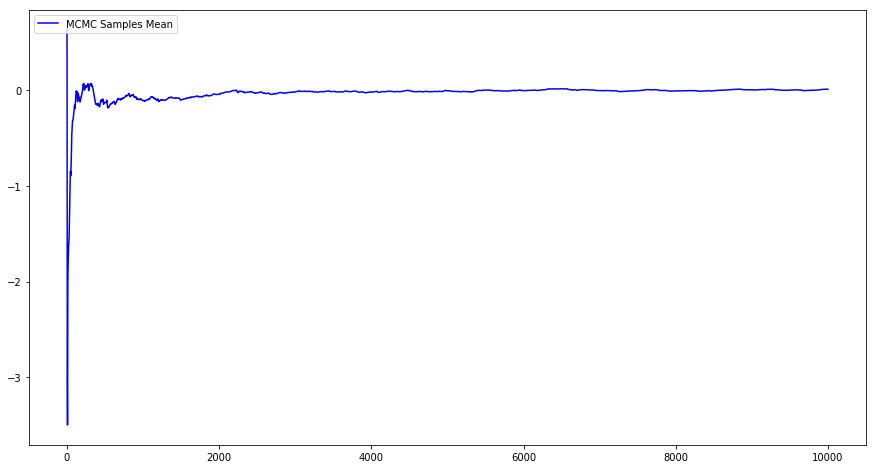

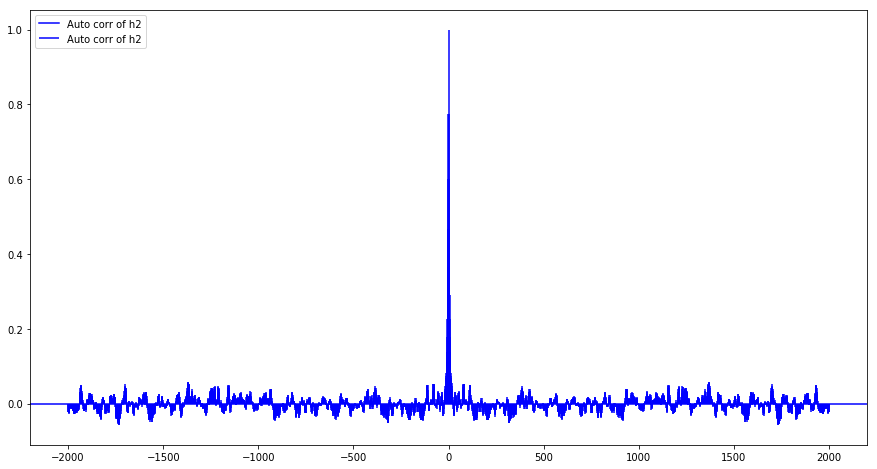

In [ ]:
average_H2=[np.mean(H2[:i]) for i in range(len(H)) if i!=0]
plt.plot(index[1:],average_H2,label=r'MCMC Samples Mean',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(subH2,label=r'Auto corr of h2',color='blue', maxlags=2000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

## Logit回归的MCMC算法
假设$d_{i}$为一个0/1变量，且给定自变量$w_{1i},w_{2i}$，$d_{i}=1$的概率为：$$P\left(d_{i}=1|w_{1i},w_{2i},\beta\right)=\frac{\exp\left\{ \beta_{0}+\beta_{1}w_{1i}+\beta_{2}w_{2i}\right\} }{1+\exp\left\{ \beta_{0}+\beta_{1}w_{1i}+\beta_{2}w_{2i}\right\} }=F\left(\beta_{0}+\beta_{1}w_{1i}+\beta_{2}w_{2i}\right)$$
因而：$$P\left(d_{i}||w_{1i},w_{2i},\beta\right)=\left[F\left(\beta_{0}+\beta_{1}w_{1i}+\beta_{2}w_{2i}\right)\right]^{d_{i}}\left[1-F\left(\beta_{0}+\beta_{1}w_{1i}+\beta_{2}w_{2i}\right)\right]^{1-d_{i}}$$现在给定一个先验分布，比如：$\beta_{j}\sim N\left(0,1\right),j=0,1,2$，那么$\beta$的后验分布为：$$\pi\left(\beta|d,w_{1},w_{2}\right)	\propto\prod_{i=1}^{N}P\left(d_{i}|w_{1i},w_{2i},\beta\right)\cdot\pi_{0}\left(\beta_{0}\right)\pi_{1}\left(\beta_{1}\right)\pi_{2}\left(\beta_{2}\right) $$
接下来我们使用MCMC算法对以上后验分布进行采样。

Mean beta0= 1.45208593007
Mean beta1= 0.993046102073
Mean beta2= -1.09819702089


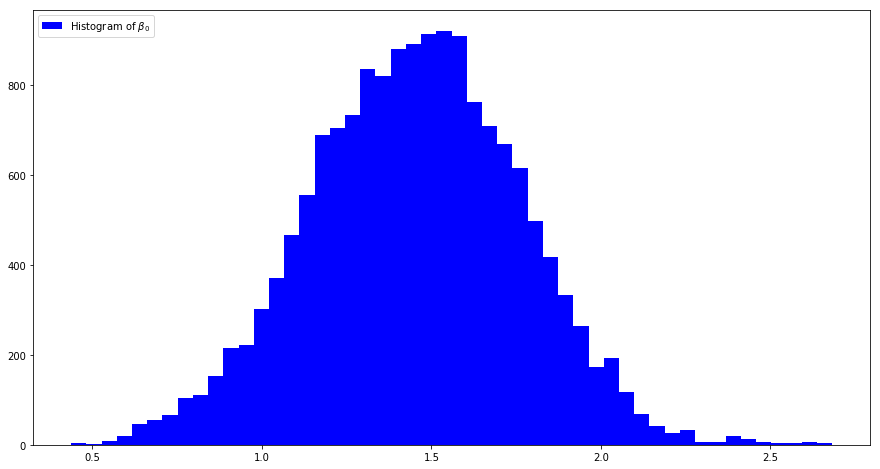

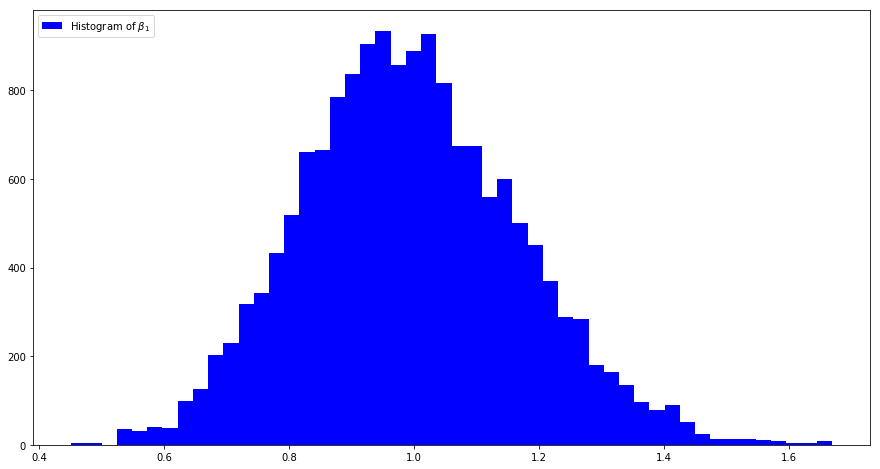

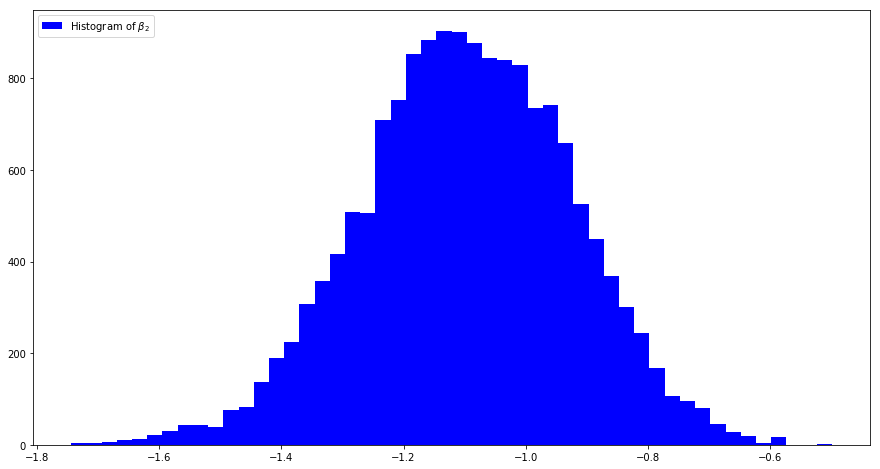

In [ ]:
import numpy as np
from numpy import random as nprd

##设定参数
M =20000
#真值
beta_0=1
beta_1=1
beta_2=-1
#样本量
N=200
#Logistic函数
Logistic=lambda x: 1.0/(1+np.exp(-1*x))

##产生数据
def gen_logit(N):
    Data=[]
    for n in range(N):
        x1=nprd.normal()*1.414+1
        x2=nprd.chisquare(2)
        d_star=beta_0+beta_1*x1+beta_2*x2
        p_star=Logistic(d_star)
        d=(1 if nprd.uniform()<p_star else 0)
        Data.append((d,x1,x2))
    return Data

#计算接受率
def rho(beta_x,beta_y,Data):
    log_post_pai_x=(-1*beta_x[0]**2-beta_x[1]**2-beta_x[2]**2)/2
    log_post_pai_y=(-1*beta_y[0]**2-beta_y[1]**2-beta_y[2]**2)/2
    log_ratio=log_post_pai_y-log_post_pai_x
    for data in Data:
        w_b_x=beta_x[0]+data[1]*beta_x[1]+data[2]*beta_x[2]
        w_b_y=beta_y[0]+data[1]*beta_y[1]+data[2]*beta_y[2]
        F_b_x=Logistic(w_b_x)
        F_b_y=Logistic(w_b_y)
        log_post_pai_x=np.log((F_b_x if data[0]==1 else 1-F_b_x))
        log_post_pai_y=np.log((F_b_y if data[0]==1 else 1-F_b_y))
        log_ratio+=(log_post_pai_y-log_post_pai_x)
    return min(1,np.exp(log_ratio))

#随机游走
def q_sampler(beta):
    return [b+nprd.normal(0,0.1) for b in beta]

##独立的MCMC算法，输入：
##    N_samples  : 抽样次数
##      rho(x,y,Data)   : 计算接受率
##   q_sampler(x): 给定x，从q中抽样的函数
##      x0       : 初始值
##     data      : 数据
def MH_RW(N_samples, rho, q_sampler, x0, data):
    X=[]
    x=x0
    for i in range(N_samples):
        y=q_sampler(x)
        if nprd.uniform()<=rho(x,y,data):
            X.append(y)
            x=y
        else:
            X.append(x)
    return X

## 从后验抽样：
data=gen_logit(N)
beta_post=MH_RW(M, rho, q_sampler, [0,0,0], data)
beta0_post=[b[0] for b in beta_post]
sub_beta0=beta0_post[int(M*0.2):]
beta1_post=[b[1] for b in beta_post]
sub_beta1=beta1_post[int(M*0.2):]
beta2_post=[b[2] for b in beta_post]
sub_beta2=beta2_post[int(M*0.2):]
#后验均值
mean_beta0=np.mean(sub_beta0)
mean_beta1=np.mean(sub_beta1)
mean_beta2=np.mean(sub_beta2)
print("Mean beta0=",mean_beta0)
print("Mean beta1=",mean_beta1)
print("Mean beta2=",mean_beta2)


import matplotlib.pyplot as plt 
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.hist(sub_beta0,label=r'Histogram of $\beta_0$',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.hist(sub_beta1,label=r'Histogram of $\beta_1$',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.hist(sub_beta2,label=r'Histogram of $\beta_2$',color='blue', bins=50)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

路径图

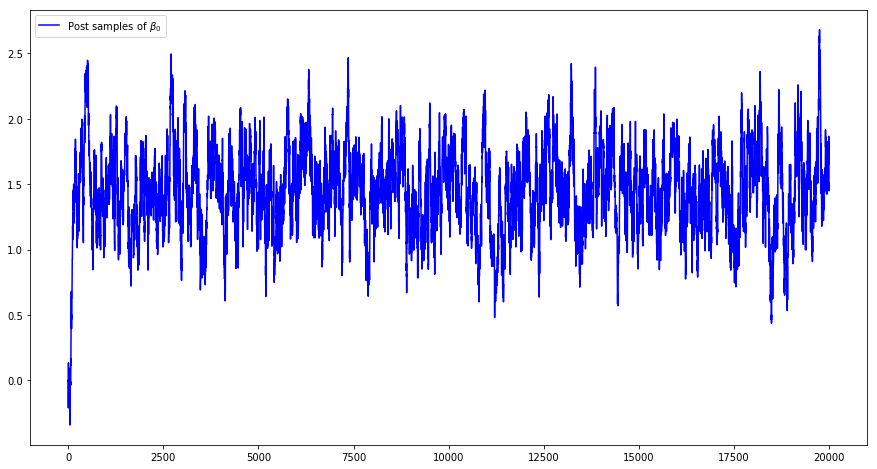

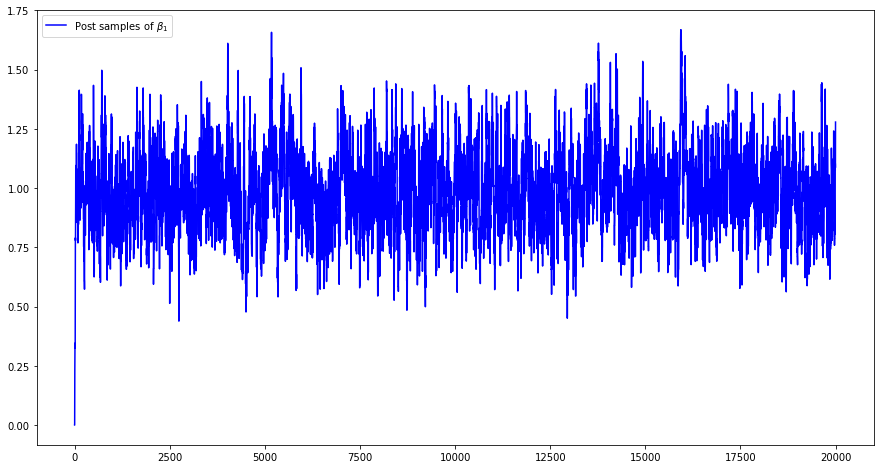

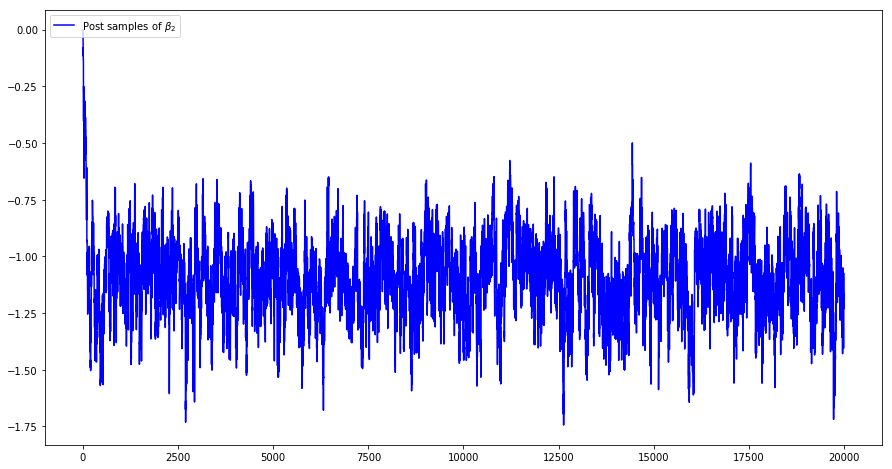

In [ ]:
index=[i for i in range(len(beta_post))]
plt.plot(index,beta0_post,label=r'Post samples of $\beta_0$',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.plot(index,beta1_post,label=r'Post samples of $\beta_1$',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.plot(index,beta2_post,label=r'Post samples of $\beta_2$',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

收敛情况

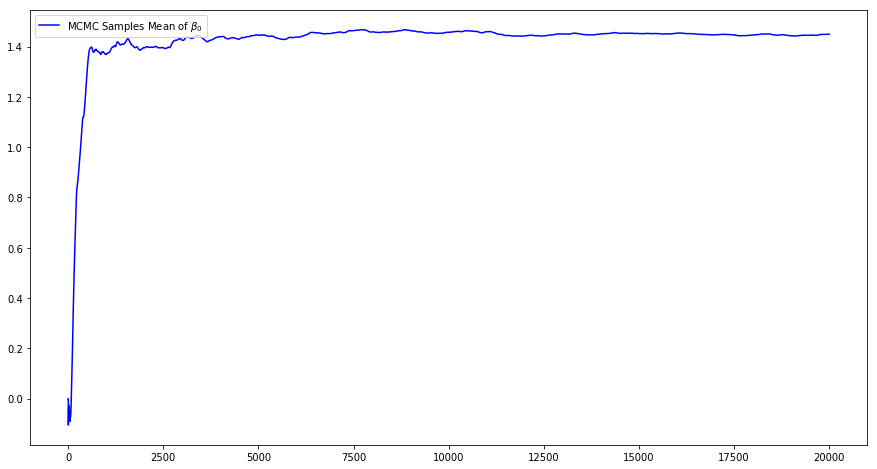

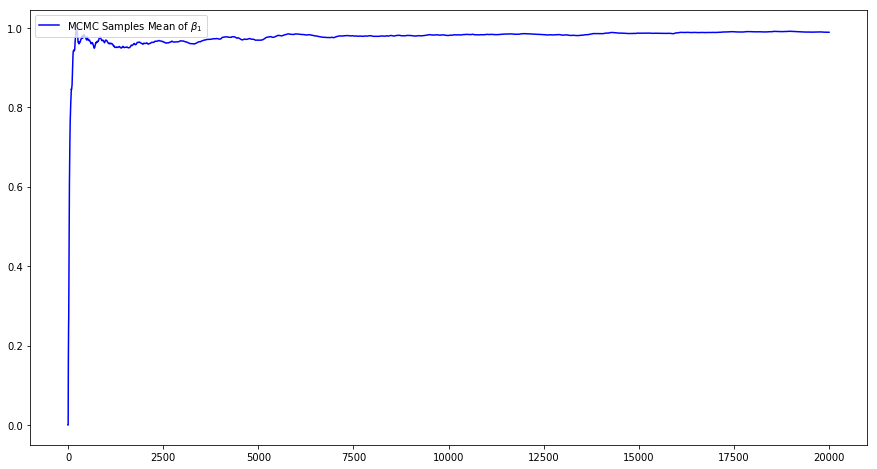

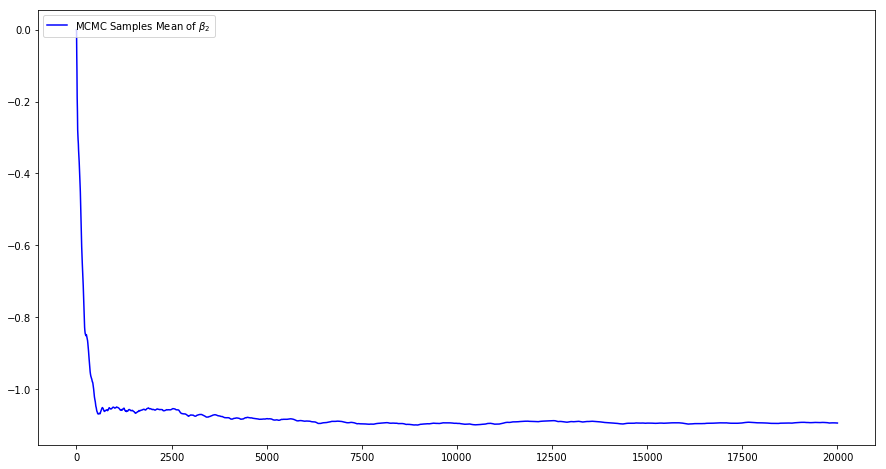

In [ ]:
average_beta0=[np.mean(beta0_post[:i]) for i in range(len(beta0_post)) if i!=0]
plt.plot(index[1:],average_beta0,label=r'MCMC Samples Mean of $\beta_0$',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
average_beta1=[np.mean(beta1_post[:i]) for i in range(len(beta1_post)) if i!=0]
plt.plot(index[1:],average_beta1,label=r'MCMC Samples Mean of $\beta_1$',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
average_beta2=[np.mean(beta2_post[:i]) for i in range(len(beta2_post)) if i!=0]
plt.plot(index[1:],average_beta2,label=r'MCMC Samples Mean of $\beta_2$',color='blue')
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图

自相关图

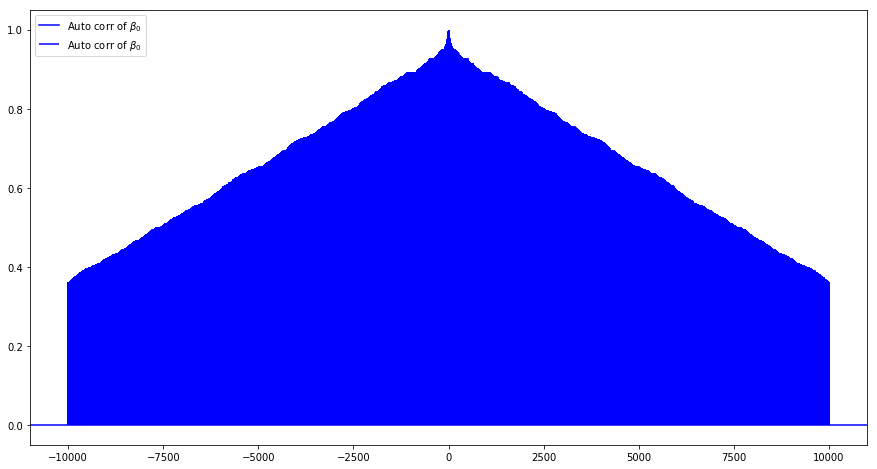

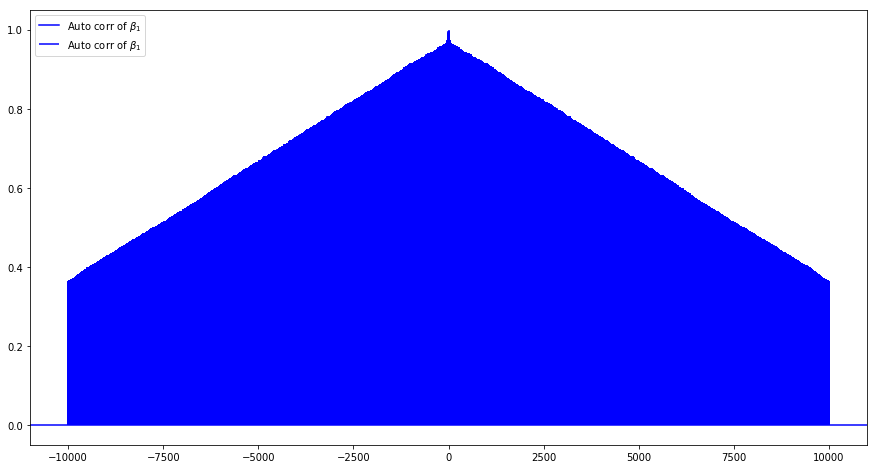

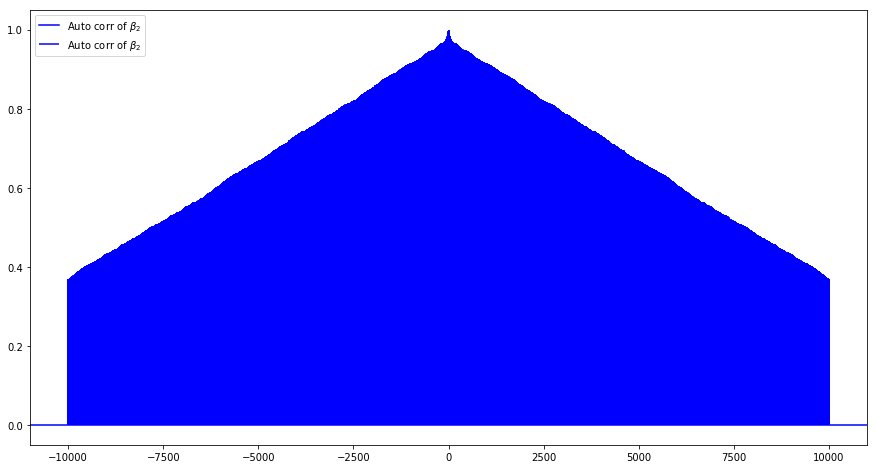

In [ ]:
plt.acorr(sub_beta0,label=r'Auto corr of $\beta_0$',color='blue', maxlags=10000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(sub_beta1,label=r'Auto corr of $\beta_1$',color='blue', maxlags=10000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图
plt.acorr(sub_beta2,label=r'Auto corr of $\beta_2$',color='blue', maxlags=10000)
plt.legend(loc='upper left', frameon=True)
plt.show() ## 画图